In [1]:
import numpy as np
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore

from matplotlib import pyplot as plt

from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree

In [36]:
from sklearn.cluster import HDBSCAN, DBSCAN

In [28]:
typestore = get_typestore(Stores.LATEST)

In [236]:
def read_bag(path):
    msgs = []
    timestamps = []
    with Reader(path) as reader:
        for connection, timestamp, data in reader.messages():
            if connection.topic != "/scan":
                continue
            msg = typestore.deserialize_cdr(data, connection.msgtype)
            msgs.append(msg)
            timestamps.append(timestamp)
    return timestamps, msgs


In [216]:
def get_points(msg):
    angles = np.linspace(msg.angle_min, msg.angle_max, len(msg.ranges), endpoint=True)
    ranges = np.array(msg.ranges)
    x = ranges * np.cos(angles)
    y = ranges * np.sin(angles)
    
    points = np.vstack((x, y)).T

    points = points[np.isfinite(points).min(axis=1).astype(bool), :]
    
    return points

In [217]:
# Calculate the center of each cluster
def calculate_cluster_centers(points, labels):
    unique_labels = set(labels)
    centers = np.zeros((len(unique_labels), 2))
    for label in unique_labels:
        if label != -1:  # Ignore noise
            class_member_mask = (labels == label)
            cluster_points = points[class_member_mask]
            center = cluster_points.mean(axis=0)
            centers[label] = center
    return centers

def find_clusters(points):
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    labels = dbscan.fit_predict(points)
    
    return calculate_cluster_centers(points, labels)

In [219]:
def track_objects(prev_positions, new_positions, max_distance):
    """
    Track objects based on their positions in consecutive measurements.
    
    Parameters:
    prev_positions (numpy.ndarray): Array of shape (N0, 2) with the positions of the objects at the previous time step.
    new_positions (numpy.ndarray): Array of shape (N1, 2) with the positions of the objects at the current time step.
    max_distance (float): Maximum distance an object is allowed to travel between measurements.
    
    Returns:
    numpy.ndarray: Array of shape (N0, 2) with the updated positions of the objects.
    """
    # Create a KDTree for fast nearest-neighbor lookup
    tree = cKDTree(new_positions)
    
    # Query the KDTree for the nearest neighbors to each point in prev_positions
    distances, indices = tree.query(prev_positions, distance_upper_bound=max_distance)
    
    # Initialize an array to store the updated positions
    updated_positions = np.copy(prev_positions)
    
    # Update positions where a valid neighbor was found within max_distance
    valid_mask = distances <= max_distance
    updated_positions[valid_mask] = new_positions[indices[valid_mask]]
    
    return updated_positions

In [228]:
def find_all_clusters(msgs):
    for msg in msgs:
        points = get_points(msg)
        clusters = find_clusters(points)
        yield clusters

In [230]:
def get_history(msgs):
    all_clusters = list(find_all_clusters(msgs))
    centers = all_clusters[0]

    history = [centers]

    for clusters in all_clusters[1:]:
        centers = track_objects(centers, clusters, 1)
        history.append(centers)

    history = np.array(history)
    
    return history

In [222]:
def bbox_area(a):
    minx, miny = a.min(axis=0)
    maxx, maxy = a.max(axis=0)
    dx = maxx - minx
    dy = maxy - miny
    return dx * dy

In [231]:
def get_largest_path(history):
    max_area = -100
    max_idx = -1
    for h in range(history.shape[1]):
        a = bbox_area(history[:, h, :])
        if a > max_area:
            max_area = a
            max_idx = h
            
    return history[: , max_idx]

In [264]:
def plot_rover_path(path):
    path = path - path[0]

    plt.figure(figsize=(10, 10))
    plt.plot(path[:, 0], path[: ,1])
    plt.gca().set_aspect('equal')
    plt.grid()

In [260]:
def store_path(ts, path, name):
    s = np.vstack((np.array(ts), path.T)).T

    np.savetxt(f'../data/2024-07-15/{name}.csv', s, delimiter=',', header='ts,x,y')

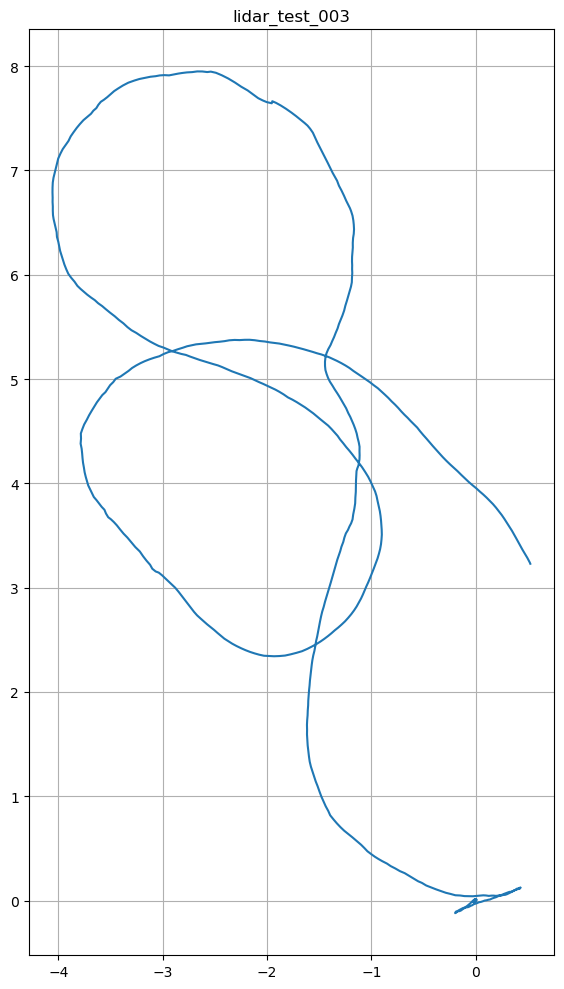

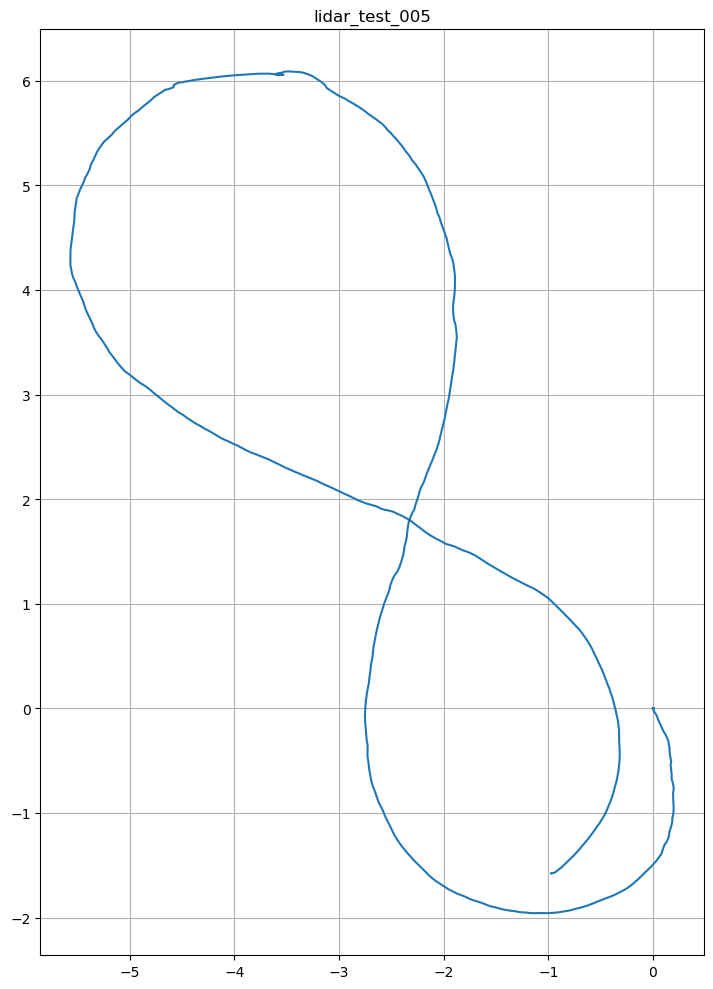

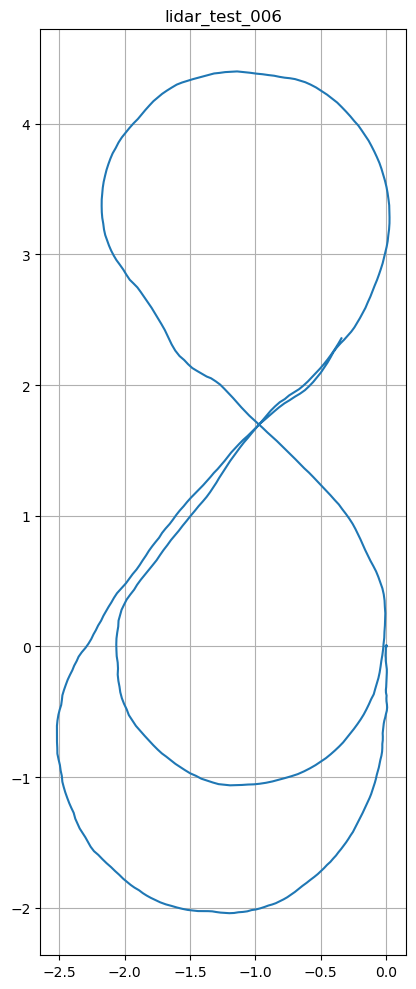

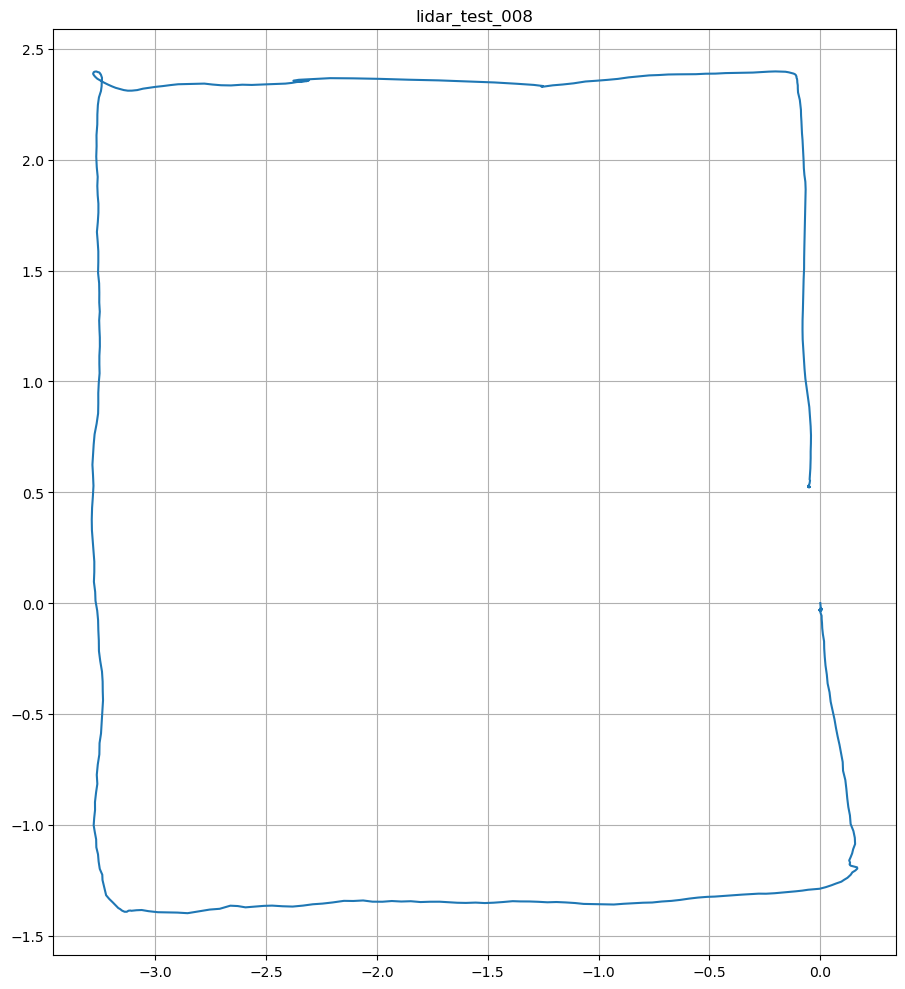

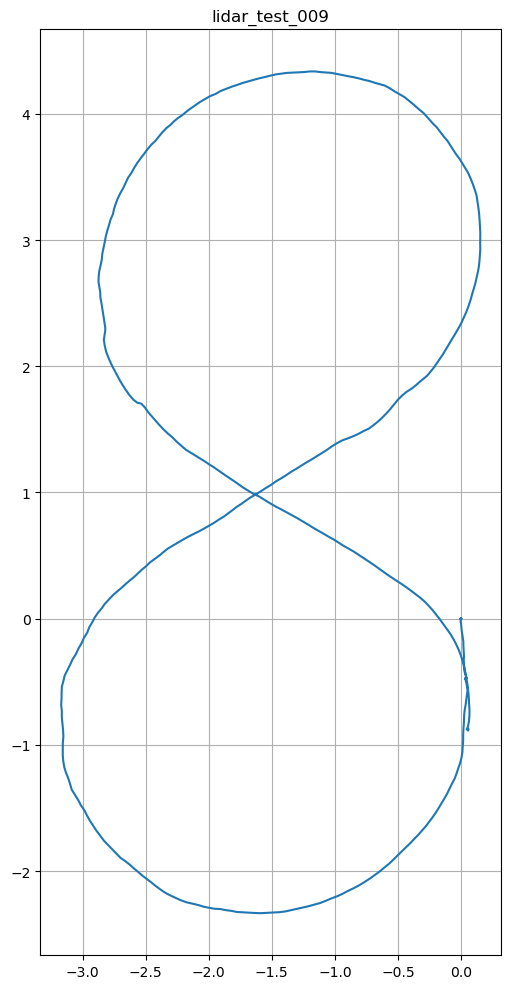

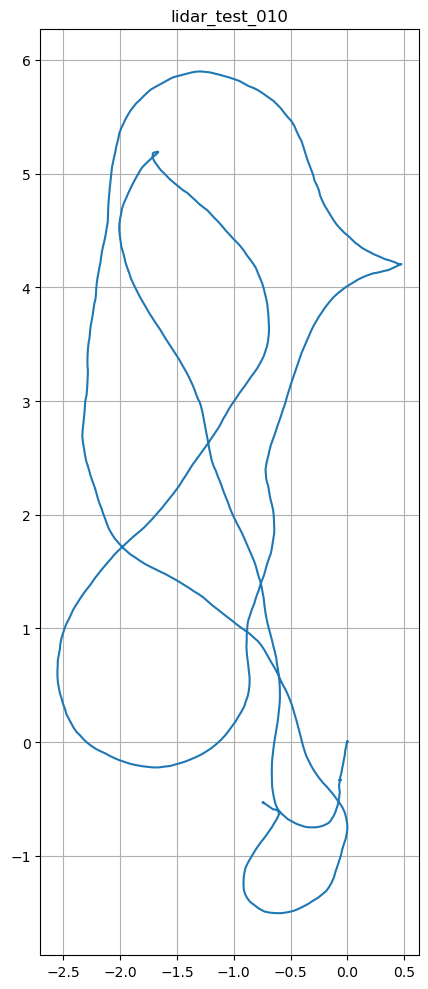

In [282]:
names = [
    'lidar_test_003',
    'lidar_test_005',
    'lidar_test_006',
    'lidar_test_008',
    'lidar_test_009',
    'lidar_test_010',
]

for name in names:

    fpath = f'../data/2024-07-15/{name}'

    ts, msgs = read_bag(fpath)
    history = get_history(msgs)
    path = get_largest_path(history)

    smoothed_path = savgol_filter(path, window_length=15, polyorder=2, axis=0)

    plot_rover_path(smoothed_path)
    store_path(ts, smoothed_path, name)

    plt.title(name)
    plt.tight_layout()
    plt.savefig(f'../data/2024-07-15/{name}.png')

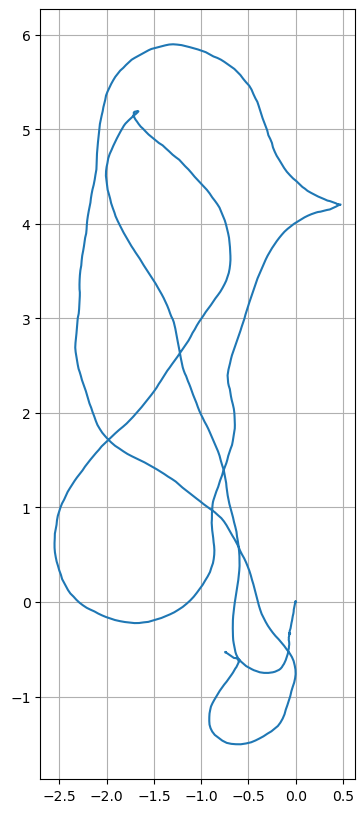

In [281]:
plot_rover_path(smoothed_path)